In [36]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re, ast, warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score

warnings.filterwarnings("ignore")

In [37]:
dataframe= pd.read_csv("flats_cleaned.csv")

In [38]:
df = dataframe[dataframe['property_type']=='flat']

In [39]:
df.shape

(2804, 13)

In [40]:
df.isnull().sum()

,0
property_type,0
sector,0
price,0
bedRoom,0
bathroom,0
balcony,0
agePossession,0
built_up_area,0
servant room,0
store room,0


In [41]:
df.drop_duplicates()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3,2,2,New Property,850.0,0,0,0,Low,Low Floor
1,flat,sector 89,0.95,2,2,2,New Property,1226.0,1,0,0,Low,Mid Floor
2,flat,sohna road,0.32,2,2,1,New Property,1000.0,0,0,0,Low,High Floor
3,flat,sector 92,1.60,3,4,3+,Relatively New,1615.0,1,0,1,High,Mid Floor
4,flat,sector 102,0.48,2,2,1,Relatively New,582.0,0,1,0,High,Mid Floor
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3544,flat,sohna road,0.27,2,2,2,New Property,640.0,0,0,0,Low,Low Floor
3546,flat,sohna road,0.87,2,2,3+,Relatively New,1131.0,0,0,0,Medium,Mid Floor
3547,flat,sector 106,0.92,2,2,3+,Relatively New,940.0,0,0,0,High,Low Floor
3549,flat,sector 84,0.37,2,2,1,Relatively New,532.0,0,0,0,Medium,Mid Floor


<Axes: >

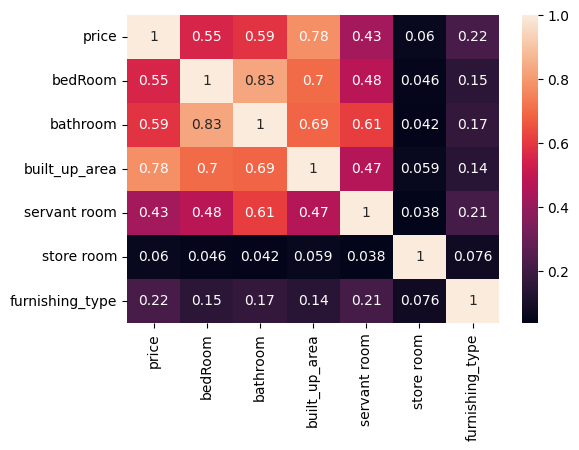

In [42]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True),annot=True)

In [43]:
object_cols = df.select_dtypes(include=['object']).columns.tolist()
alpha = 0.05

chi2_results = {}

df['price_bin'] = pd.qcut(df['price'], q=4, labels=False)

for col in object_cols:
  contingency = pd.crosstab(df[col], df['price_bin'])
  chi2_stat, p_val, _, _ = chi2_contingency(contingency)
  decision = 'Reject Null (Keep Feature)' if p_val < alpha else 'Accept Null (Drop Feature)'
  chi2_results[col] = {
          'chi2_statistic': chi2_stat,
          'p_value': p_val,
          'Decision': decision
  }

chi2_df = pd.DataFrame(chi2_results).T
chi2_df = chi2_df.sort_values(by='p_value')
chi2_df

,chi2_statistic,p_value,Decision
sector,2608.154831,0.0,Reject Null (Keep Feature)
balcony,755.56621,0.0,Reject Null (Keep Feature)
luxury_category,171.450568,0.0,Reject Null (Keep Feature)
floor_category,81.722296,0.0,Reject Null (Keep Feature)
agePossession,52.071161,0.000001,Reject Null (Keep Feature)
property_type,0.0,1.0,Accept Null (Drop Feature)


In [44]:
df = df.drop(['store room','property_type', 'price_bin'], axis=1)
df.head()

,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,furnishing_type,luxury_category,floor_category
0,sector 36,0.82,3,2,2,New Property,850.0,0,0,Low,Low Floor
1,sector 89,0.95,2,2,2,New Property,1226.0,1,0,Low,Mid Floor
2,sohna road,0.32,2,2,1,New Property,1000.0,0,0,Low,High Floor
3,sector 92,1.60,3,4,3+,Relatively New,1615.0,1,1,High,Mid Floor
4,sector 102,0.48,2,2,1,Relatively New,582.0,0,0,High,Mid Floor


In [45]:
df.nunique()

,0
sector,98
price,359
bedRoom,6
bathroom,7
balcony,5
agePossession,5
built_up_area,1228
servant room,2
furnishing_type,3
luxury_category,3


In [46]:
feature_mappings = {}

In [47]:
# df = pd.get_dummies(df, columns=['luxury_category','floor_category','agePossession','balcony','bathroom','bedRoom'])

In [48]:
# df[df.select_dtypes(bool).columns] = df.select_dtypes(bool).astype(int)

In [49]:
for col in df.select_dtypes(include=['object']).columns.tolist():
    if df[col].dtype == object:  # only encode categorical features
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        feature_mappings[col] = pd.DataFrame({
            'Index': range(len(encoder.classes_)),
            col: encoder.classes_
        })

In [50]:
# Display mapping DataFrames
for feature, mapping_df in feature_mappings.items():
    print(f"Mapping for '{feature}':")
    print(mapping_df, "\n")

Mapping for 'sector':
    Index             sector
0       0  dwarka expressway
1       1        gwal pahari
2       2            manesar
3       3           sector 1
4       4          sector 10
..    ...                ...
93     93          sector 92
94     94          sector 93
95     95          sector 95
96     96          sector 99
97     97         sohna road

[98 rows x 2 columns] 

Mapping for 'balcony':
   Index balcony
0      0       0
1      1       1
2      2       2
3      3       3
4      4      3+ 

Mapping for 'agePossession':
   Index       agePossession
0      0      Moderately Old
1      1        New Property
2      2        Old Property
3      3      Relatively New
4      4  Under Construction 

Mapping for 'luxury_category':
   Index luxury_category
0      0            High
1      1             Low
2      2          Medium 

Mapping for 'floor_category':
   Index floor_category
0      0     High Floor
1      1      Low Floor
2      2      Mid Floor 



In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2804 entries, 0 to 3553
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sector           2804 non-null   int64  
 1   price            2804 non-null   float64
 2   bedRoom          2804 non-null   int64  
 3   bathroom         2804 non-null   int64  
 4   balcony          2804 non-null   int64  
 5   agePossession    2804 non-null   int64  
 6   built_up_area    2804 non-null   float64
 7   servant room     2804 non-null   int64  
 8   furnishing_type  2804 non-null   int64  
 9   luxury_category  2804 non-null   int64  
 10  floor_category   2804 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 262.9 KB


In [52]:
df = df.rename(columns={'servant room': 'servant_room'})

In [53]:
df.head()

,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant_room,furnishing_type,luxury_category,floor_category
0,32,0.82,3,2,2,1,850.0,0,0,1,1
1,89,0.95,2,2,2,1,1226.0,1,0,1,2
2,97,0.32,2,2,1,1,1000.0,0,0,1,0
3,93,1.60,3,4,4,3,1615.0,1,1,0,2
4,5,0.48,2,2,1,3,582.0,0,0,0,2


In [54]:
X = df.drop(['price'], axis=1)
y = df['price']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [56]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Fit model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # R²
    r2 = r2_score(y_test, y_pred)

    # Adjusted R²
    n = X_test.shape[0]  # number of samples
    p = X_test.shape[1]  # number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

    # Errors
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    medae = median_absolute_error(y_test, y_pred)

    return {
        "model": type(model).__name__,
        "r2": round(float(r2), 4),
        "adjusted_r2": round(float(adjusted_r2), 4),
        # "mae": round(float(mae), 2),
        # "mse": round(float(mse), 2),
        "rmse": round(float(rmse), 2),
        # "medae": round(float(medae), 2)
    }

In [57]:
models = [
    LinearRegression(),
    SVR(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
]

results = []
for m in models:
    results.append(evaluate_model(m, X_train, y_train, X_test, y_test))

# Display results
import pandas as pd
pd.DataFrame(results)

,model,r2,adjusted_r2,rmse
0,LinearRegression,0.6109,0.6038,0.76
1,SVR,0.6294,0.6227,0.75
2,DecisionTreeRegressor,0.4297,0.4193,0.92
3,RandomForestRegressor,0.7948,0.7911,0.55
4,GradientBoostingRegressor,0.8116,0.8082,0.53
5,XGBRegressor,0.8458,0.8430,0.48


In [58]:
import joblib
joblib.dump(models[5],'flats_xgb.pkl')

['flats_xgb.pkl']

In [59]:
model_xgb = models[5]
y_pred = model_xgb.predict(X_test)
y = y_test.to_list()
for i in range(0,10):
  print(f"predicted: {y_pred[i]} actual: {y[i]}")

predicted: 0.809532105922699 actual: 0.99
predicted: 1.3526827096939087 actual: 1.25
predicted: 2.297766923904419 actual: 2.25
predicted: 0.8799260854721069 actual: 1.0
predicted: 0.7063992619514465 actual: 0.85
predicted: 1.7556532621383667 actual: 1.9
predicted: 5.442139148712158 actual: 3.2
predicted: 2.5734448432922363 actual: 2.01
predicted: 1.8308721780776978 actual: 1.25
predicted: 1.4518070220947266 actual: 1.07
